In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from packages.Model_GANomaly import GANomaly

## MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [3]:
x_train_1 = x_train[y_train == 1]

x_test_1_7 = x_test[(y_test == 1) | (y_test == 7)]
y_test_1_7 = y_test[(y_test == 1) | (y_test == 7)]

## Model

In [4]:
ganomaly = GANomaly()

In [5]:
model = ganomaly.get_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 16)           8480        ['input_5[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 28, 28, 1)    8345        ['model[0][0]']                  
                                                                                                  
 model_3 (Functional)           (None, 4, 4, 16)     8480        ['input_5[0][0]',                
                                                                  'model_1[0][0]']          

In [6]:
G_model = ganomaly.get_G_model()
G_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 16)                8480      
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         8345      
                                                                 
Total params: 16,825
Trainable params: 16,765
Non-trainable params: 60
_________________________________________________________________


In [7]:
D_model = ganomaly.get_D_model()
D_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_3 (Functional)        (None, 4, 4, 16)          8480      
                                                                 
 global_average_pooling2d_2   (None, 16)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 8,497
Trainable params: 8,437
Non-trainable params: 60
_________________________________________________________________


## Traning

In [8]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    counts = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        counts += 1
        for i in range(round(datalen/batch_size)):
            train_x = data[idxes[i*batch_size: (i+1) * batch_size]]
            y = np.ones(train_x.shape[0])
            yield train_x, [y, y, y]

In [9]:
train_data_generator = get_data_generator(x_train_1, batch_size=32)

In [10]:
for i in range(2000):
    # get batch x, y
    x, y = train_data_generator.__next__()

    # train disciminator
    D_model.trainable = True

    fake_x = G_model(x)

    d_x = tf.concat([x, fake_x], axis=0)
    d_y = tf.concat([tf.zeros(x.shape[0]), tf.ones(x.shape[0])], axis=0)

    d_loss = D_model.train_on_batch(d_x, d_y)

    # train generator
    D_model.trainable = False        
    g_loss = model.train_on_batch(x, y)

    if i % 100 == 0:
        print(f'iter: {i+1:4d} d_loss: {d_loss:1.4f} \
g_loss: [{g_loss[0]:2.4f}, {g_loss[1]:1.4f}, {g_loss[2]:1.4f}, {g_loss[3]:1.4f}]')

iter:    1 d_loss: 0.8794 g_loss: [6.0117, 0.6096, 0.0889, 0.1610]
iter:  101 d_loss: 0.1539 g_loss: [2.3954, 0.0763, 0.0364, 0.0099]
iter:  201 d_loss: 0.1150 g_loss: [1.9735, 0.0716, 0.0307, 0.0093]
iter:  301 d_loss: 0.1554 g_loss: [1.9202, 0.1212, 0.0296, 0.0100]
iter:  401 d_loss: 0.1114 g_loss: [1.7774, 0.1014, 0.0278, 0.0071]
iter:  501 d_loss: 0.0996 g_loss: [1.7634, 0.0904, 0.0281, 0.0095]
iter:  601 d_loss: 0.0882 g_loss: [1.8431, 0.0860, 0.0302, 0.0106]
iter:  701 d_loss: 0.0863 g_loss: [1.4883, 0.0780, 0.0235, 0.0078]
iter:  801 d_loss: 0.0661 g_loss: [1.2431, 0.0772, 0.0190, 0.0047]
iter:  901 d_loss: 0.0564 g_loss: [1.3425, 0.0603, 0.0214, 0.0062]
iter: 1001 d_loss: 0.0524 g_loss: [1.5607, 0.0736, 0.0256, 0.0090]
iter: 1101 d_loss: 0.0550 g_loss: [1.1774, 0.0717, 0.0182, 0.0045]
iter: 1201 d_loss: 0.0450 g_loss: [1.4745, 0.0582, 0.0243, 0.0120]
iter: 1301 d_loss: 0.0408 g_loss: [1.3420, 0.0685, 0.0216, 0.0081]
iter: 1401 d_loss: 0.0377 g_loss: [1.1221, 0.0492, 0.0178, 0.0

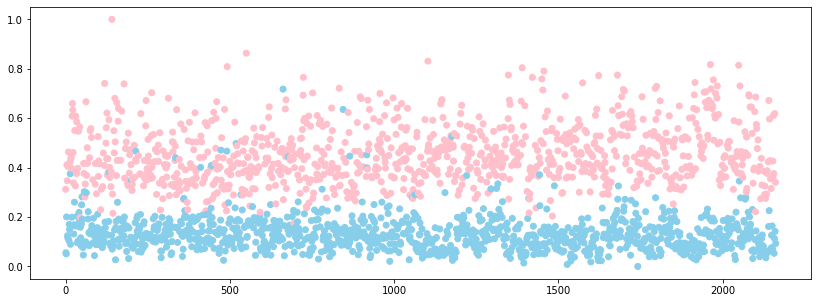

In [15]:
encoded = ganomaly.Ge.predict(x_test_1_7)
encoded_gan = ganomaly.Ge.predict(G_model.predict(x_test_1_7))
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score))

c = ['skyblue' if x == 1 else 'pink' for x in y_test_1_7]
plt.figure(figsize=(14, 5))
plt.scatter(range(len(x_test_1_7)), score, c=c)
plt.show()

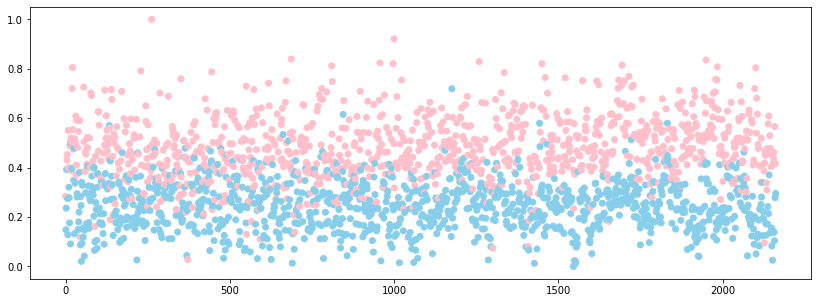

In [12]:
encoded = ganomaly.Ge.predict(x_test_1_7)
encoded_gan = ganomaly.E.predict(G_model.predict(x_test_1_7))
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score))

c = ['skyblue' if x == 1 else 'pink' for x in y_test_1_7]
plt.figure(figsize=(14, 5))
plt.scatter(range(len(x_test_1_7)), score, c=c)
plt.show()

In [13]:
x_test_1_7[:10].shape

(10, 28, 28, 1)

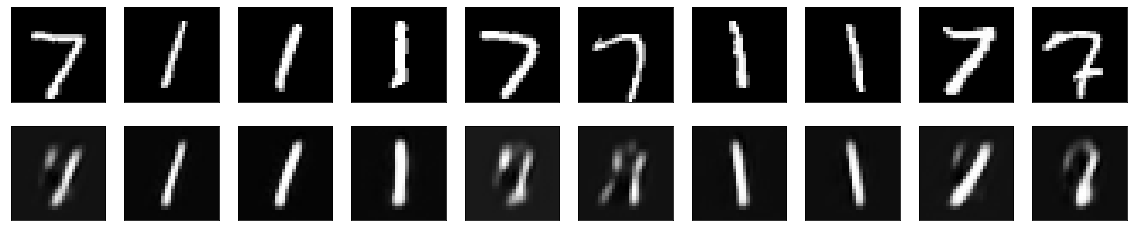

In [14]:
number = 10  # how many digits we will display
images = x_test_1_7[:10]
AE_images = (ganomaly.Ge(x_test_1_7[:10]))
plt.figure(figsize=(20, 4))
for index in range(number):
    # 加了雜訊的圖像
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_1_7[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 重建的圖像
    ax = plt.subplot(2, number, index + 1 + number)
    img = G_model.predict(x_test_1_7[index].reshape(1, 28, 28, 1)).reshape(28, 28)
    plt.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()